### t-SNE 可视化算法

t-SNE 是一种流形学习算法，目的是在保留数据点局部信息的情况下对非线性数据点进行降维。
具体方法是：
 - 把数据点的空间关系转化成概率分布。利用数据点的高斯联合分布来近似表达原来数据点的空间位置
 $$p_{j|i}=\frac{exp(-|x_i-x_j|^2/2\sigma_i^2)}{\sum_{k\neq i}exp (-|x_i-x_k|)^2/2\sigma_i^2}$$
 - 利用学生分布来表达目标平面的位置关系
 $$q_{j|i}=\frac{(1+|y_i-y_j|^2)^{-1}}{\sum_{k\neq l}(1+|y_k-y_l|^2)^{-1}}$$

为了降维以后尽可能保持原来数据点的局部信息，最小化相对熵：
$$C=\sum_iD(P_i||Q_i)=\sum_i\sum_jp_{j|i}\log\frac{p_{j|i}}{q_{j|i}}$$

细节可以参考：[Visualizing Data using t-SNE by G.Hinton and L.Maaten](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)



t-SNE: 94 sec


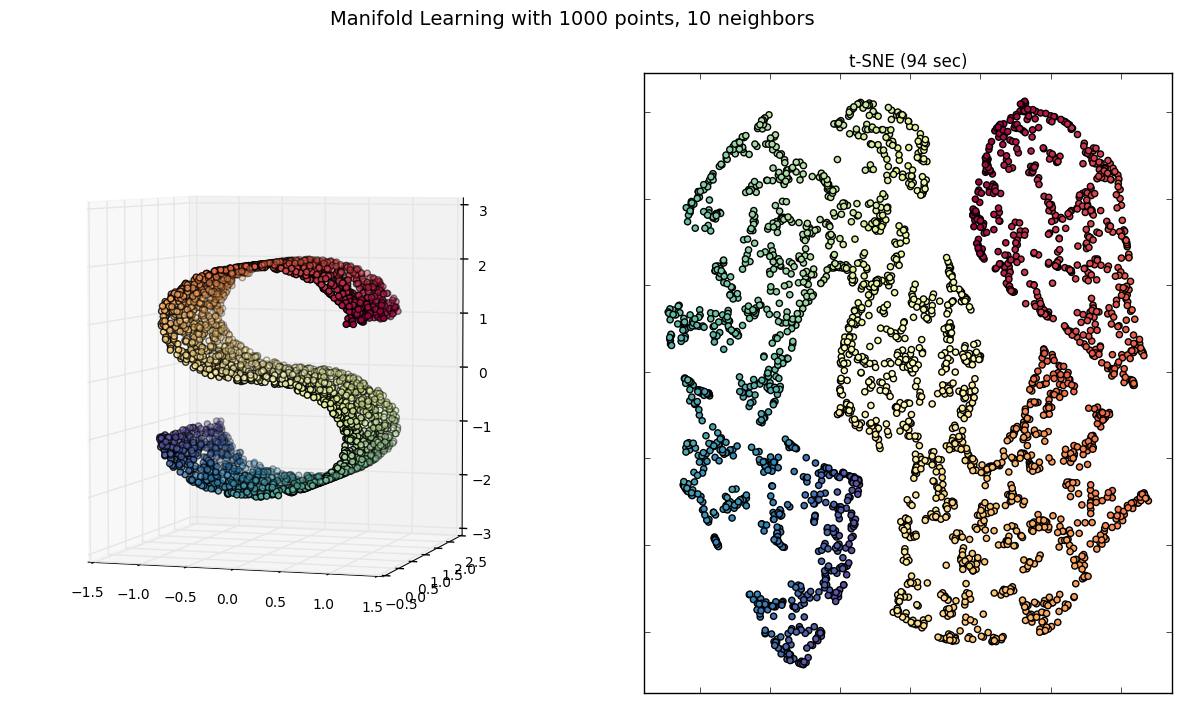

In [14]:
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 3000
X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)


ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)


t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(1, 2, 2)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

t-SNE: 27 sec


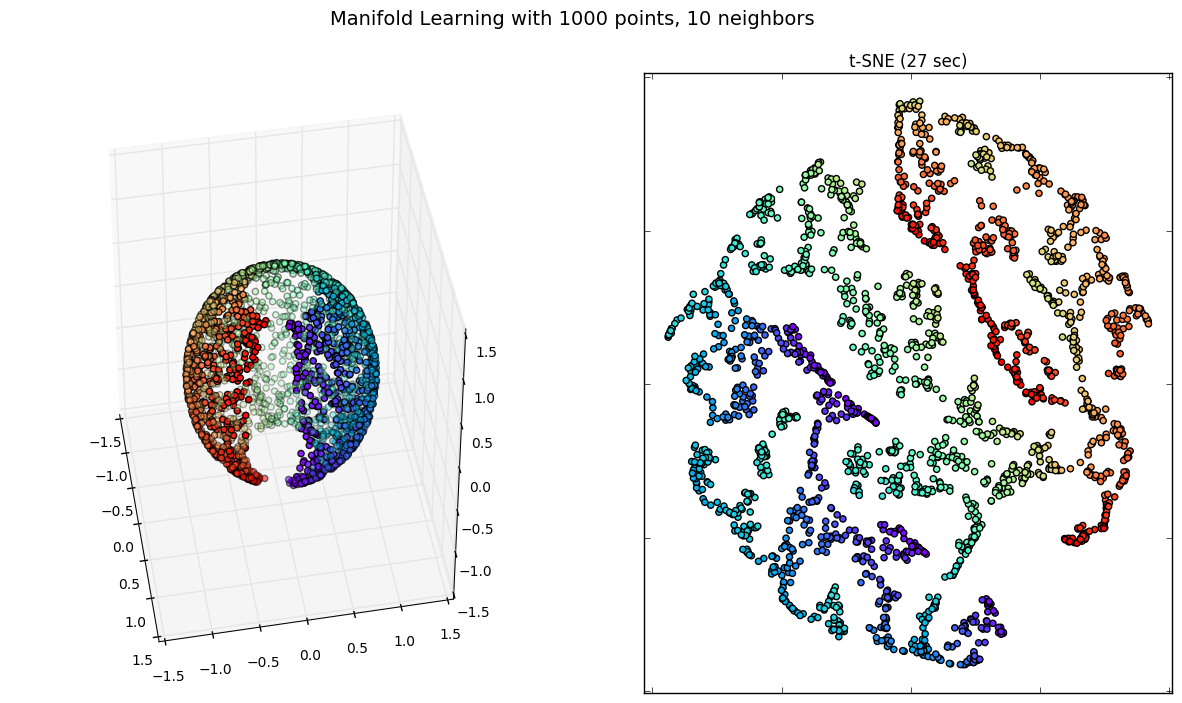

In [13]:
import numpy as np

from sklearn.utils import check_random_state

# Next line to silence pyflakes.
Axes3D

# Variables for manifold learning.
n_neighbors = 10
n_samples = 3000

# Create our sphere.
random_state = check_random_state(0)
p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
t = random_state.rand(n_samples) * np.pi

# Sever the poles from the sphere.
indices = ((t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8))))
colors = p[indices]
x, y, z = np.sin(t[indices]) * np.cos(p[indices]), \
    np.sin(t[indices]) * np.sin(p[indices]), \
    np.cos(t[indices])

# Plot our dataset.
fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

ax = fig.add_subplot(121, projection='3d')
ax.scatter(x, y, z, c=p[indices], cmap=plt.cm.rainbow)
ax.view_init(40, -10)

sphere_data = np.array([x, y, z]).T

# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
trans_data = tsne.fit_transform(sphere_data).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(1, 2, 2)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

# 最大熵模型 自然语言处理

In [21]:
from collections import defaultdict
import numpy as np

# 最大熵模型进行垃圾邮件分类，数据集如下：第一列是标签，spam or nonSpam, 后面是标题关键词
"""
Y    X
Spam discount Sexy
Spam discount Sexy school
Spam discount Sexy market
Spam discount Sexy school
Spam discount Sexy  market 
Spam Club Happy  market
Spam Club Happy  market 
Spam Club Sad  market
Spam Club Sad  market
nonSpam information Happy market
nonSpam information Happy School
nonSpam information Sad School
nonSpam information Sad market
nonSpam Club Sad  market
nonSpam Club Sad  market

f1(x,y) = 1 if y == 'spam' and x == 'discount'
f2(x,y) = 1 if y == 'nonSpam' and x == 'information'

"""


class maxEntropy(object):
    #初始化数据集
    def __init__(self):
        self.trainset = []
        self.features = defaultdict(int)
        self.labels = set([])
        self.w = []

    #导入数据集
    def loadData(self, fName):
        for line in open(fName):
            fields = line.strip().split()
            # at least two columns
            if len(fields) < 2: continue 
            # the first column is label
            label = fields[0]
            self.labels.add(label) 
            for f in set(fields[1:]):
                # (label,f) tuple is feature
                self.features[(label, f)] += 1
            self.trainset.append(fields)
            self.w = [0.0] * len(self.features)
            self.lastw = self.w

    def train(self, max_iter=1000):
        self.initP() 
        for i in range(max_iter):
            self.ep = self.EP()
            self.lastw = self.w[:]
            for i, w in enumerate(self.w):
                self.w[i] += (1.0 / self.M) * np.log(self.Ep_[i] / self.ep[i])
            if self.convergence():
                break

    def initP(self):
        self.M = max([len(feature[1:]) for feature in self.trainset])
        self.size = len(self.trainset)
        self.Ep_ = [0.0] * len(self.features)
        for i, feat in enumerate(self.features):
            self.Ep_[i] += self.features[feat] / (1.0 * self.size)
            self.features[feat] = i
        self.w = [0.0] * len(self.features)
        self.lastw = self.w

    def EP(self):
        ep = [0.0] * len(self.features)
        for record in self.trainset:
            features = record[1:]
            # cal pyx
            prob = self.calPyx(features)
            for f in features:  
                for pyx, label in prob:
                    if (label, f) in self.features:
                        id = self.features[(label, f)]
                        ep[id] += (1.0 / self.size) * pyx
        return ep

    def calPyx(self, features):
        wlpair = [(self.calSumP(features, label), label) for label in self.labels]
        Z = sum([w for w, l in wlpair])
        prob = [(w / Z, l) for w, l in wlpair]
        return prob

    def calSumP(self, features, label):
        sumP = 0.0
        for showedF in features:
            if (label, showedF) in self.features:
                sumP += self.w[self.features[(label, showedF)]]
        return np.exp(sumP)

    def convergence(self):
        for i in range(len(self.w)):
            if abs(self.w[i] - self.lastw[i]) >= 0.001:
                return False
        return True

    def predict(self, input):
        features = input.strip().split()
        prob = self.calPyx(features)
        prob.sort(reverse=True)
        return prob


if __name__ == '__main__':
    mxEnt = maxEntropy()
    mxEnt.loadData('max_entropy.txt')
    mxEnt.train()
    prediction = mxEnt.predict('school discount')
    for value in prediction:
        print()
        print ("The probability for this message to be %s is %.3f"%(value[1], value[0]))
        print()


The probability for this message to be Spam is 0.990


The probability for this message to be nonSpam is 0.010

